# Quantization-aware training VGG16

Quantization-aware model training ensures that the forward pass matches precision for both training and inference.The quantization error is modeled using fake quantization nodes to simulate the effect of quantization in the forward and backward passes. The forward-pass models quantization, while the backward-pass models quantization as a straight-through estimator. Both the forward- and backward-pass simulate the quantization of weights and activations. Note that during back propagation, the parameters are updated at high precision as this is needed to ensure sufficient precision in accumulating tiny adjustments to the parameters.

**Model quantization**

Quantizing deep neural networks uses techniques that allow for reduced precision representations of weights and, optionally, activations for both storage and computation. Quantization provides several benefits:

    - Support on existing CPU platforms.
    - Quantization of activations reduces memory access costs for reading and storing intermediate activations.
    - Many CPU and hardware accelerator implementations provide SIMD instruction capabilities, which are especially beneficial for quantization.

In [ ]:
!mkdir checkpoints

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)

1.14.0


Using TensorFlow backend.


In [2]:
def get_train_for_keras(input_csv):
    original_data = pd.read_csv(input_csv)
    df_train_for_keras = original_data.loc[original_data['is_valid'] == False, ['relative_path', 'label']]
    df_train_for_keras = df_train_for_keras.astype(str)
    return df_train_for_keras

def get_val_for_keras(input_csv):
    original_data = pd.read_csv(input_csv)
    df_val_for_keras = original_data.loc[original_data['is_valid'] == True, ['relative_path', 'label']]
    df_val_for_keras = df_val_for_keras.astype(str)
    return df_val_for_keras

def get_test_for_keras(input_csv):
    original_data = pd.read_csv(input_csv)
    df_test_for_keras = original_data[['relative_path', 'label']]
    df_test_for_keras = df_test_for_keras.astype(str)
    return df_test_for_keras

df_train_for_keras = get_train_for_keras(str(pathlib.Path.cwd()) + "/temp/" + "train_val_group.csv")
print(len(df_train_for_keras))

df_val_for_keras = get_val_for_keras(str(pathlib.Path.cwd()) + "/temp/" + "train_val_group.csv")
print(df_val_for_keras[:5])

df_test_for_keras = get_test_for_keras(str(pathlib.Path.cwd()) + "/temp/" + "test_group.csv")
print(len(df_val_for_keras)+len(df_train_for_keras)+len(df_test_for_keras))

directory = str(pathlib.Path.cwd()) + "/raw_datasets/images/plantVillage"

38070
                                           relative_path label
38070   Pepper,_bell___Bacterial_spot/JR_B.Spot 3293.JPG    18
38071        Squash___Powdery_mildew/UMD_Powd.M 0707.JPG    25
38072              Apple___Apple_scab/FREC_Scab 3120.JPG     0
38073               Grape___Black_rot/FAM_B.Rot 3107.JPG    11
38074  Tomato___Tomato_Yellow_Leaf_Curl_Virus/UF.GRC_...    35
54272


In [3]:
train_datagen = ImageDataGenerator(featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rescale=1./255,
                                   rotation_range=25,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_generator = train_datagen.flow_from_dataframe(df_train_for_keras,
                                                    directory=directory,
                                                    x_col='relative_path',
                                                    y_col='label',
                                                    target_size=(224, 224),
                                                    batch_size=64,
                                                    drop_duplicates=False)
val_generator = val_datagen.flow_from_dataframe(df_val_for_keras,
                                                directory=directory,
                                                x_col='relative_path',
                                                y_col='label',
                                                target_size=(224, 224),
                                                batch_size=64,
                                                shuffle=False,
                                                drop_duplicates=False)

Found 38070 validated image filenames belonging to 38 classes.
Found 5251 validated image filenames belonging to 38 classes.


### Build the model

- define build_keras_model function since we have to build model 2 times (for train and eval)

In [11]:
from keras.models import Sequential
from keras.applications import ResNet50
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from keras.optimizers import SGD
from keras import models
from keras import layers
from keras import optimizers
from keras import metrics
import os


def build_keras_model():
  #Load the ResNet50 model
    
    classes = 38
    model = Sequential()
    model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation='softmax',name='classifier'))

    model.layers[0].trainable = False
    
    return model



In [12]:
model= build_keras_model()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
classifier (Dense)           (None, 38)                77862     
Total params: 23,665,574
Trainable params: 77,862
Non-trainable params: 23,587,712
_________________________________________________________________


## Train model and save it's checkpoints

- Use new Session and Graph to ensure that we can use absolutory same name of variables for train and eval phase.
- call `tf.contrib.quantize.create_training_graph` after building model since we want to do Quantization Aware Training

In [14]:
train_graph = tf.get_default_graph()

train_sess = tf.Session(graph=train_graph)


keras.backend.set_session(train_sess)
with train_sess.as_default():
    with train_graph.as_default():
        train_model = build_keras_model()

        tf.contrib.quantize.create_training_graph(input_graph=train_graph, quant_delay=100)
        train_sess.run(tf.global_variables_initializer())    

        #opt = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
        train_model.compile(loss="categorical_crossentropy", optimizer="adam",
           metrics=[metrics.categorical_accuracy])

        history = train_model.fit_generator(train_generator,
                                  steps_per_epoch=849,
                                  epochs=20,
                                  validation_data=val_generator,
                                  validation_steps=170)         
        # save graph and checkpoints
        saver = tf.train.Saver()
        saver.save(train_sess, os.path.join(os.getcwd(),'checkpoints'))
    #predictions = train_model.predict(testX)

INFO:tensorflow:Skipping quant after add_1/add
INFO:tensorflow:Skipping quant after add_2/add
INFO:tensorflow:Skipping quant after add_3/add
INFO:tensorflow:Skipping quant after add_4/add
INFO:tensorflow:Skipping quant after add_5/add
INFO:tensorflow:Skipping quant after add_6/add
INFO:tensorflow:Skipping quant after add_7/add
INFO:tensorflow:Skipping quant after add_8/add
INFO:tensorflow:Skipping quant after add_9/add
INFO:tensorflow:Skipping quant after add_10/add
INFO:tensorflow:Skipping quant after add_11/add
INFO:tensorflow:Skipping quant after add_12/add
INFO:tensorflow:Skipping quant after add_13/add
INFO:tensorflow:Skipping quant after add_14/add
INFO:tensorflow:Skipping quant after add_15/add
INFO:tensorflow:Skipping quant after add_16/add
INFO:tensorflow:Skipping quant after add_17/add
INFO:tensorflow:Skipping quant after add_18/add
INFO:tensorflow:Skipping quant after add_19/add
INFO:tensorflow:Skipping quant after add_20/add
INFO:tensorflow:Skipping quant after add_21/add
I

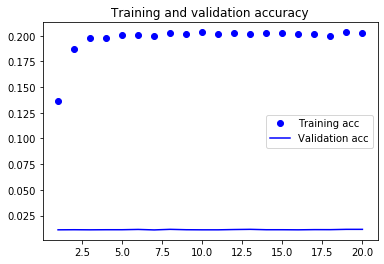

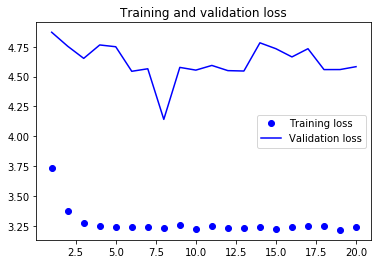

In [15]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Freeze model and save it

- Create new Session and Graph
- Call `tf.contrib.quantize.create_eval_graph` and get graph_def after building model before saver.restore
- Call `saver.restore` to load the trained weights.
   - saver.restore may add unneeded variables to the graph. So we have to get the graph_def before save.restore is called.
- We can use `tf.graph_util.convert_variables_to_constants` to freeze the graph_def

In [ ]:
# eval
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpu_options = tf.GPUOptions(allow_growth=True)
#sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
eval_graph = tf.Graph()
eval_sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)

keras.backend.set_session(eval_sess)

with eval_graph.as_default():
    keras.backend.set_learning_phase(0)
    eval_model = build_keras_model()
    tf.contrib.quantize.create_eval_graph(input_graph=eval_graph)
    eval_graph_def = eval_graph.as_graph_def()
    saver = tf.train.Saver()
    saver.restore(eval_sess, 'checkpoints')

    frozen_graph_def = tf.graph_util.convert_variables_to_constants(
        eval_sess,
        eval_graph_def,
        [eval_model.output.op.name]
    )

    with open('ResNet50_frozen_model.pb', 'wb') as f:
        f.write(frozen_graph_def.SerializeToString())